# Support Vector Machine (SVM) Classification

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [2]:
data = TrinaryData()
data.df_X.head()

,0,1,2,3,4,5,6,7,8,9,...,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514
T2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T5,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1
T6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,1,1,1,1,1,1,1,1,1,1


In [3]:
dir(data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'df_X',
 'features',
 'provider',
 'ser_y',
 'state_dict']

## Feature Selection
Determine how many features to include.

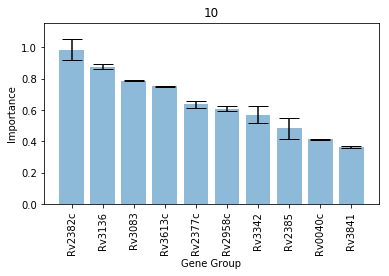

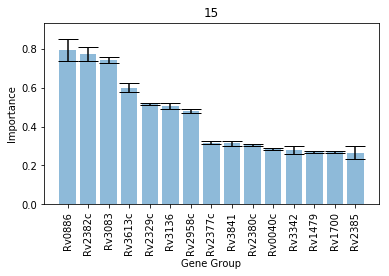

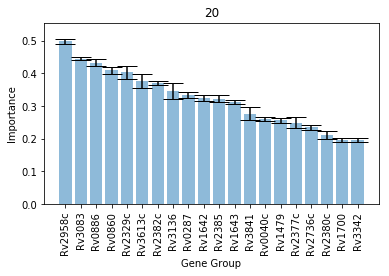

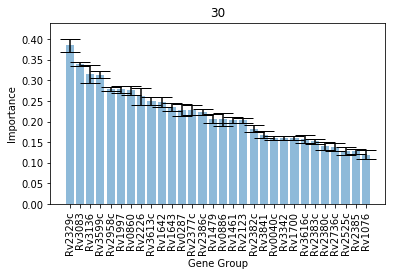

In [4]:
# Assess how many features should be included
for filter in [10, 15, 20, 30]:
    svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), filter_high_rank=filter, size=30)
    df_X = data.df_X.copy()
    df_X.columns = data.features
    svm_ensemble.fit(df_X, data.ser_y)
    # Analysis to determine how many features should be considered
    svm_ensemble.plotImportance(title="%d" % filter)
    #svm_ensemble.plotRank()

## Assess Model Quality With Cross Validation
Need to assess the hyperparameters: number of classifiers, number of features.

In [5]:
def calcCVR(num_classifiers, num_features, num_iterations=10):
     clf = classifier_ensemble.ClassifierEnsemble(
         classifier_ensemble.ClassifierDescriptorSVM(),
         filter_high_rank=num_features, size=num_classifiers)
     return classifier_collection.ClassifierCollection.crossValidateByState(
         clf, data.df_X, data.ser_y, num_iterations)


In [17]:
# Construct a heatmap across the hyperparameter space for mean classification accuracy
# May be more interesting to do a bar plot for number features
# Observe that accuracy degrades with too many features. Get accuracy 1.0 at 15
calcCVR(20, 1515)

CrossValidationResult(mean=0.9780000000000001, std=0.036276714294434104, collection=<common_python.classifier.classifier_collection.ClassifierCollection object at 0x7f6a46815c88>)

In [6]:
STOP HERE
clfs = [lin_clf, lin_clf]
classes = [0, 1, 2, 3, 4]
def predict(df_X):
    """ 
    Default prediction algorithm. Reports probability of each class.
    :param pd.DataFrame: features, indexed by instance.
    """
    # Change to an array of array of features
    DUMMY_COLUMN = "dummy_column"
    array = df_X.values
    array = array.reshape(len(df_X), -1) 
    # Create a dataframe of class predictions
    clf_predictions = [clf.predict(df_X) for clf in clfs]
    instance_predictions = [dict(collections.Counter(x)) for x in zip(*clf_predictions)]
    df = pd.DataFrame()
    df[DUMMY_COLUMN] = np.repeat(-1, len(classes))
    for idx, instance in enumerate(instance_predictions):
        ser = pd.Series([x for x in instance.values()], index=instance.keys())
        df[idx] = ser
    del df[DUMMY_COLUMN]
    df = df.applymap(lambda v: 0 if np.isnan(v) else v)
    df = df / len(clfs)
    return df

SyntaxError: invalid syntax (<ipython-input-6-5eb1bc9d579e>, line 1)

In [ ]:
df = data.df_X.loc[["T5", "T10", "T20"], :]
predict(df)

In [ ]:
predicted_class = []
for index in data.df_X.index:
     predicted = lin_clf.predict(data.df_X.loc[[index],:])[0]
     predicted_class.append(predicted)

In [ ]:
predicted_class

In [ ]:
# Predicting a class
lin_clf.predict(data.df_X.loc[["T18"],:])

In [ ]:
for n in range(5):
    plt.figure()
    plt.scatter(range(1515), lin_clf.coef_[n])

In [ ]:
# Analysis of rank of gene for multiple iterations of cross validations
df_X = data.df_X.copy()
for holdouts in [1, 2]:
    df_X.columns = data.features
    result = classifier_ensemble.LinearSVMEnsemble.crossValidate(df_X, data.ser_y,
                                                                 iterations=500, holdouts=holdouts)
    result.ensemble.plotRank(top=30, title="Holdouts: %d" % holdouts, ylim=(0,160))
    result.ensemble.plotImportance(top=30, title="Holdouts: %d" % holdouts, ylim=(0, 0.02))

In [ ]:
# Random forest
df_X = data.df_X.copy()
df_X.columns = data.features
ensemble = classifier_ensemble.RandomForestEnsemble(df_X, data.ser_y, num_iterations=20,
                        n_estimators=5000, max_features=1500, random_state=0,
                        min_samples_split=2, bootstrap=True)
result.ensemble.plotRank(top=30, title="Random Forest", ylim=(0,160))
result.ensemble.plotImportance(top=30, title="Random Forest")

In [ ]:
states = data.ser_y.unique().tolist()
holdouts = 1
result = classifier_ensemble.LinearSVMEnsemble.crossValidate(data.df_X, data.ser_y,
    classifier_args={"C": 0.5}, iterations=500, holdouts=holdouts)
for state in states:   
    result.ensemble.plotRank(class_selection=state, top=20, title="State: %d" % state, ylim=(0,20))

In [ ]:
def evaluateRankFilter(high_rank,ylim=(-1,1), is_feature_columns=True):
    states = data.ser_y.unique().tolist()
    states.sort()
    df_X = data.df_X.copy()
    if is_feature_columns:
        df_X.columns = data.features
    holdouts = 1
    result = classifier_ensemble.LinearSVMEnsemble.crossValidate(df_X, data.ser_y,
        filter_high_rank=high_rank, iterations=500, holdouts=holdouts)
    print("Accuracy: %f2.4 +/- %f2.4"% (result.mean, result.std))
    for state in states:   
        result.ensemble.plotImportance(class_selection=state, top=high_rank, title="State: %d" % state, ylim=ylim)

In [ ]:
evaluateRankFilter(None, ylim=(-0.02, 0.02), is_feature_columns=False)

In [ ]:
evaluateRankFilter(15)

In [ ]:
result.mean, result.std

**Observations**
1. Rv3574 is associated with lipid metabolism and virulence. Rv3573c is upregulated in state 2 (hypoxia). Maybe in the same regulon?
1. There are many genes that are perfectly correlated with Rv3573c.
1. Consider some kind of feature selection to reduce the number of parameters (since C regularization in SVM doesn't seem to work). Select based on rank variance for each classifier?
1. KstR, Rv3574, is key to regulation in anoxia lipid metabolism.